In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt

## Progress bar
from tqdm.notebook import tqdm

In [2]:
import torch
print("Using torch", torch.__version__)

Using torch 1.12.1+cu102


In [3]:
class Layer:
    
    # constructor that takes in layer config
    # this is only for starting initial layers, everything else should configure through attach
    def __init__(self, input_nodes, activation=torch.nn.ReLU()):  
        self.input_nodes = input_nodes
        self.activation = activation
        self.weights = []
        self.fire_trackers = []
        self.outputs = []
        self.output_layers = []
        
    # takes an existing layer and attaches a newly created layer to the output of this one
    # note that to make a complete layer it must have a fixed input and output shape, so this is non-mutating
    def attach(self, layer_nodes):
        new_layer = Layer(layer_nodes)
        self.output_layers.append(new_layer)
        
        new_layer_weights = torch.zeros((self.input_nodes, layer_nodes,))
        torch.nn.init.normal_(new_layer_weights, std=0.02)
        self.weights.append(new_layer_weights)
        self.fire_trackers.append(torch.zeros((self.input_nodes, layer_nodes,)))
        # print("new layer created with shape", new_layer_weights.shape)
        
        return new_layer
        
    # torch multiply input by layer weights
    # store outputs on layer for training
    # call eval on layers set as downstream to this one
    # in future when recursive layers are supported, 
    # inputs may need to come with an id so that a layer doesn't track its upstream relationships as closely
    def eval(self, input):
        # print("intput and weight check", input.shape, self.weights.shape)
        self.input = input
        self.outputs = []
        for i, output_layer in enumerate(self.output_layers):
            output = torch.matmul(input, self.weights[i])
            output = self.activation(output)
            self.outputs.append(output)
            
            # print("outputSheck", output.shape)
        
        for i, output_layer in enumerate(self.output_layers):
            # print("eval with", self.outputs[i])
            output_layer.eval(self.outputs[i])
            
    def train(self, reward, learning_rate, decay_rate):
        # for now we will skip specialization based on whether output fires or not
        # whole network is also skipping bias
        # down the line we may want to add some constant input to enable similar behavior
        for i, output in enumerate(self.outputs):
            # print("train", self.weights[i].shape, self.input.shape, output.shape)
            weight_contributions = self.input * self.weights[i].transpose(0,1)
            # print("conts", weight_contributions.shape, self.fire_trackers[i].shape)
            self.fire_trackers[i] += weight_contributions.transpose(0, 1)
            self.fire_trackers[i] *= decay_rate
            self.weights[i] += self.fire_trackers[i] * learning_rate * reward

        return
    
    def mutate(self, std_dev):
        new_layer = self.clone()
        for weight in new_layer.weights:
            mutation = torch.randn(weight.shape) * std_dev
            weight += mutation
            
        return new_layer
        
    def clone(self):
        new_layer = Layer(self.input_nodes)
        
        for weight in self.weights:
            new_layer.weights.append(weight)
            
        for fire_tracker in self.fire_trackers:
            new_layer.fire_trackers.append(torch.clone(fire_tracker))
            
        for output in self.outputs:
            new_layer.outputs.append(torch.clone(output))
            
        # this wont work as the layers are not tensors
        # we can clone here though so the clone is recursive
        # this will break with recursive layers though?
        for output_layer in self.output_layers:
            new_layer.output_layers.append(output_layer)
        
        return new_layer
    
    def reset(self):
        for i, fire_tracker in enumerate(self.fire_trackers):
            self.fire_trackers[i] = torch.zeros(fire_tracker.shape)
        

In [4]:
class Network:
    
    # setup network
    # create collections that will store inputs, layers, layer relationships?, and outputs
    def __init__(self):
        self.layers = []
        
    # take in list of input shapes, return a corresponding layer for each of them
    def set_input(self, input_shapes):
        self.inputs = []
        for input_shape in input_shapes:
            layer = Layer(input_shape, activation=torch.nn.Identity())
            self.layers.append(layer)
            self.inputs.append(layer)
        
        return self.inputs
        
    # take in a list of layers and set them as the output
    # this way eval method can return whatever the outputs are configured to be
    def set_output(self, output_layers):
        self.output_layers = []
        for output_layer in output_layers:
            self.output_layers.append(output_layer)
        
    # take in inputs
    # eval them on each of the set input layers
    # layer eval pushes state to other layers at runtime
    # so evaling layers should result in outputs being set
    # outputs will be stored on layers anyways for weight adjustment
    # so can just return outputs from registered output layers
    def eval(self, inputs):
        for i, input in enumerate(inputs):
            self.inputs[i].eval(input)
            
        outputs = []
        for output in self.output_layers:
            # print("output", output.input)
            outputs.append(output.input)
                
            
        return outputs
        
    # will adjust network weights based on current outputs stored on the layers
    # should this take in learning rate so that something outside network can adjust this as needed?
    def train(self, reward, learning_rate, decay_rate):
        for layer in self.layers:
            layer.train(reward, learning_rate, decay_rate)
            
        return
    
    def mutate(self, std_dev):
        new_layer = self.clone()
        return
    
    def reset(self):
        return
    
    def clone(self):
        for weight in self.inputs:
            new_layer.weights.append(weight)
            
        for weight in self.output_layers:
            new_layer.weights.append(weight)
            
        for weight in self.layers:
            new_layer.weights.append(weight)
            
        return new_layer
    

In [5]:
input = torch.zeros((1, 10,))
input[0][0] = -1
network = Network()
input_layers = network.set_input((10,))
hidden_layer1 = input_layers[0].attach(100)
hidden_layer2 = hidden_layer1.attach(2)
network.set_output((hidden_layer2,))

output = network.eval((input,))
print(output)

[tensor([[0.0000, 0.0088]])]


In [6]:
import gym
torch.manual_seed(0)
env = gym.make('Acrobot-v1')
fitnesses = []

network = Network()
input_layers = network.set_input((6,))
hidden_layer1 = input_layers[0].attach(64)
hidden_layer2 = hidden_layer1.attach(64*2)
hidden_layer3 = hidden_layer2.attach(3)
network.set_output((hidden_layer3,))

# attempt loop
for i in range(100):
    network.reset()
    
    # NOTE! the seed changing on the env is enabling exploration
    # we NEED an exploration element to this algorithm
    observation, info = env.reset(seed=42)#)# seed=42
    fitness = 0
    reward = 0
    angle = 0
    
    # experience loop
    for k in range(1000):
        input = torch.tensor(observation)
        new_input = input.reshape((1, 4))
        # print("input", new_input)
        output = network.eval(new_input)
        # print("output ", output)
        action = torch.argmax(output[0]).item()
        # print("action ", action)
        
        prev_reward = reward
        observation, reward, terminated, truncated, info = env.step(action)
        fitness += reward

        reward = -cos(theta1) - cos(theta2 + theta1)
        
        angle = cur_angle
        
        #if terminated or truncated:
        #    reward = -10
            
        #print(reward, angle)
        network.train(reward, .001, .9)

        # have some kind of counter to enforce that we run each network through x lifetimes
        # also add to some fitness counter as we go
        if terminated or truncated:
            # print("reset", terminated, truncated)
            terminated = False
            truncated = False
            break

    fitnesses.append(fitness)
    #print("Fitness: ", fitness)
        
    # take top n networks and make copies of them
    # log fitnesses of top 10 + avg pop fitness
    # consider using the child model where we also mutate to make the next generation
    # should probably verify base algorithm first though
plt.cla()
plt.plot(fitnesses)
plt.show()
        

RuntimeError: shape '[1, 4]' is invalid for input of size 6

In [8]:
organisms = []
for i in range(0, 100):
    network = Network()
    input_layers = network.set_input((4,))
    hidden_layer1 = input_layers[0].attach(100)
    hidden_layer2 = hidden_layer1.attach(2)
    network.set_output((hidden_layer2,))
    organisms.append(network)

In [9]:
import gym
env = gym.make("CartPole-v1", render_mode='rgb_array')
observation, info = env.reset()# seed=42

# generation loop
for i in range(100):
    fitnesses = []
    for j, network in enumerate(organisms):
        # eval loop
        print("Eval org ", j, "in generation ", i)
        observation, info = env.reset()# seed=42
        fitness = 0
        for k in range(1000):
            input = torch.tensor(observation)
            new_input = input.reshape((1, 4))
            # print("input", new_input)
            output = network.eval(new_input)
            # print("output ", output)
            action = torch.argmax(output[0]).item()
            # print("action ", action)
            observation, reward, terminated, truncated, info = env.step(action)
            network.train()
            
            # make reward negative if terminated
            fitness += reward
            
            # have some kind of counter to enforce that we run each network through x lifetimes
            # also add to some fitness counter as we go
            if terminated or truncated:
                # print("reset", terminated, truncated)
                terminated = False
                truncated = False
                break
                observation, info = env.reset()
                network.reset()
        
        fitnesses.append((fitness, j))
        print("Fitness: ", fitness)
        
    # take top n networks and make copies of them
    # log fitnesses of top 10 + avg pop fitness
    # consider using the child model where we also mutate to make the next generation
    # should probably verify base algorithm first though
        

Eval org  0 in generation  0


TypeError: train() missing 3 required positional arguments: 'reward', 'learning_rate', and 'decay_rate'

AttributeError: 'function' object has no attribute 'display'

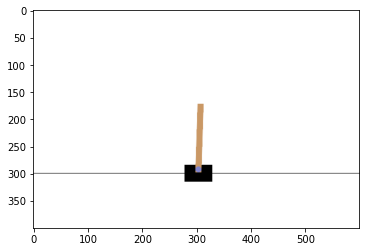

In [10]:
import gym
env = gym.make("CartPole-v1", render_mode='rgb_array')
observation, info = env.reset(seed=42)

for _ in range(100):
    #mode='rgb_array')
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)

    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    #print(observation)

    if terminated or truncated:
        print("reset", terminated, truncated)
        break
        observation, info = env.reset()
env.close()

In [ ]:
# make set of random networks
# let each run through env n times, training at each step and resetting prev fires when env is terminal
# next take top m models and use those as population
# repeat until fitness reaches goal / time runs out